# Library Import

In [262]:
import yfinance as yf
from datetime import datetime
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Get YFinance Data

In [263]:
today = datetime.now().strftime("%Y-%m-%d")

STOCK_NAME = 'META'
START_DAY = '1900-01-01'
END_DAY = today
INTERVAL = '1d'

data = yf.download(STOCK_NAME, START_DAY, END_DAY, INTERVAL)
print(data.head())
print(f'Length of DataFrame : {len(data)}')

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.115242  573576400   
2012-05-21  36.529999  36.660000  33.000000  34.029999  33.927845  168192700   
2012-05-22  32.610001  33.590000  30.940001  31.000000  30.906942  101786600   
2012-05-23  31.370001  32.500000  31.360001  32.000000  31.903940   73600000   
2012-05-24  32.950001  33.209999  31.770000  33.029999  32.930847   50237200   

            Dividends  Stock Splits  
Date                                 
2012-05-18        0.0           0.0  
2012-05-21        0.0           0.0  
2012-05-22        0.0           0.0  
2012-05-23        0.0           0.0  
2012-05-24        0.0           0.0  
Length of DataFrame : 3121


# Handle DataFrame

In [264]:
## 오늘 종가대비 내일 종가 상승, 하락 열
data['Label'] = data['Adj Close'].shift(-1)
data['Label'] = data['Label'].combine(data['Adj Close'], lambda x, y: 1 if x > y else -1)

## 거래량 변화량 열
data['Volume Change'] = data['Volume'].pct_change()
data['Volume Change'] = round(np.exp(data['Volume Change']), 3)

## 시가 변화량 열
data['Open Change'] = round(((data['Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)) * 100, 3)

## 고가 변화량 열
data['High Change'] = round(((data['High'] - data['High'].shift(1)) / data['High'].shift(1)) * 100, 3)

## 저가 변화량 열
data['Low Change'] = round(((data['Low'] - data['Low'].shift(1)) / data['Low'].shift(1)) * 100, 3)

data = data.dropna()
data = data.iloc[1:50]
print(data.head())

change_ratio = data['Label'].value_counts(normalize=True) * 100

print("Change 열의 비율:")
for value, count in change_ratio.items():
    if value == 1:
        print(f"상승: {count:.2f}%")
    elif value == -1:
        print(f"하락: {count:.2f}%")

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2012-05-22  32.610001  33.590000  30.940001  31.000000  30.906942  101786600   
2012-05-23  31.370001  32.500000  31.360001  32.000000  31.903940   73600000   
2012-05-24  32.950001  33.209999  31.770000  33.029999  32.930847   50237200   
2012-05-25  32.900002  32.950001  31.110001  31.910000  31.814211   37149800   
2012-05-29  31.480000  31.690001  28.650000  28.840000  28.753426   78063400   

            Dividends  Stock Splits  Label  Volume Change  Open Change  \
Date                                                                     
2012-05-22        0.0           0.0    1.0          0.674       -3.884   
2012-05-23        0.0           0.0    1.0          0.758        1.498   
2012-05-24        0.0           0.0   -1.0          0.728        3.279   
2012-05-25        0.0           0.0   -1.0          0.771       -0.09

## DataFrame Clustering

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2012-05-22  32.610001  33.590000  30.940001  31.000000  30.906942  101786600   
2012-05-23  31.370001  32.500000  31.360001  32.000000  31.903940   73600000   
2012-05-24  32.950001  33.209999  31.770000  33.029999  32.930847   50237200   
2012-05-25  32.900002  32.950001  31.110001  31.910000  31.814211   37149800   
2012-05-29  31.480000  31.690001  28.650000  28.840000  28.753426   78063400   
2012-05-30  28.700001  29.549999  27.860001  28.190001  28.105379   57267900   
2012-05-31  28.549999  29.670000  26.830000  29.600000  29.511147  111639200   
2012-06-01  28.889999  29.150000  27.389999  27.719999  27.636787   41855500   
2012-06-04  27.200001  27.650000  26.440001  26.900000  26.819250   35230300   
2012-06-05  26.700001  27.760000  25.750000  25.870001  25.792343   42473400   
2012-06-06  26.070000  27.170000  25.520

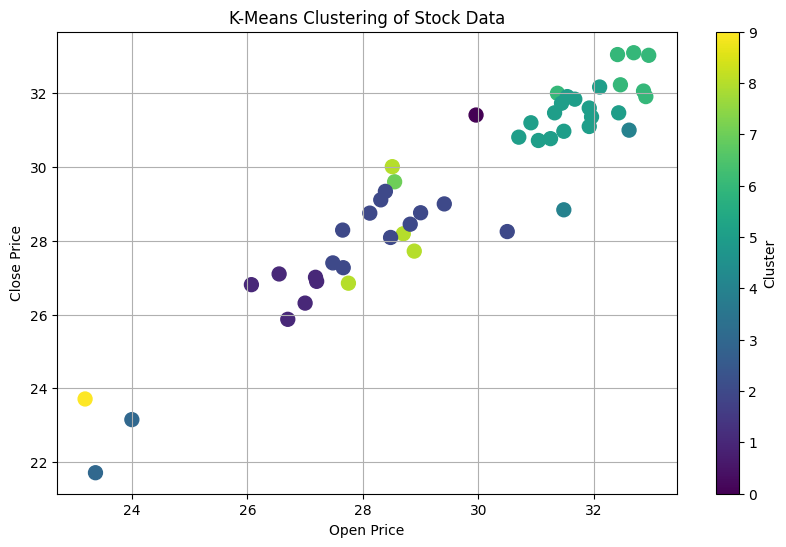

In [265]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

kmeans = KMeans(n_clusters=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

centers = kmeans.cluster_centers_
distances = np.linalg.norm(scaled_data[:, np.newaxis] - centers, axis=2)
data['Cluster Distance'] = distances[np.arange(len(distances)), data['Cluster']]
data['Cluster Proba'] = round(1 / (1 + data['Cluster Distance']), 3)      # 거리가 작을 수록 소속도가 높음.
data = data.drop(columns=['Cluster Distance'])

print(data)

plt.figure(figsize=(10, 6))
plt.scatter(data['Open'], data['Close'], c=data['Cluster'], cmap='viridis', s=100)
plt.title('K-Means Clustering of Stock Data')
plt.xlabel('Open Price')
plt.ylabel('Close Price')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


## Make Graph

In [266]:
G = nx.DiGraph()        # 방향 엣지
# G = nx.Graph()        # 단방향 엣지

## 베이스 노드 만들기
# G.add_node("A", age=25, gender="M")
G.add_node("Up")
G.add_node("Down")

## 인덱스 노드 만들기
for index in data.index.astype(str):
    OC = data.loc[index, 'Open Change']
    HC = data.loc[index, 'High Change']
    LC = data.loc[index, 'Low Change']
    G.add_node(f'{index}', OC = OC, HC = HC, LC = LC)
    
## 클러스터 노드 만들기
for index in data.index.astype(str):
    CLUSTER = data.loc[index, 'Cluster']
    G.add_node(f'Clust_{int(CLUSTER)}')
    
## 인덱스 노드 -> 베이스 노드 엣지 연결
for index in data.index.astype(str):
    label = data.loc[index, 'Label']
    if label == 1:
        G.add_edge(f'{index}', 'Up')
    else:
        G.add_edge(f'{index}', 'Down')

## 전 날 인덱스 노드 -> 오늘 인덱스 노드 엣지 연결
cnt = 1
pre_index = ''
for index in data.index.astype(str):
    if cnt == 1:
        pre_index = index
        cnt += 1
    else:
        G.add_edge(f'{pre_index}', f'{index}', weight = data.loc[index, 'Volume Change'])
        pre_index = index

## 인덱스 노드 -> 클러스터 노드 연결
for index in data.index.astype(str):
    CLUSTER = data.loc[index, 'Cluster']
    G.add_edge(f'{index}', f'Clust_{int(CLUSTER)}', weight = data.loc[index, 'Cluster Proba'])

# 노드 정보 출력
print("노드 정보:")
for node in G.nodes(data=True):
    print(node)

# 엣지 정보 출력
print("\n엣지 정보:")
for edge in G.edges(data=True):
    print(edge)

노드 정보:
('Up', {})
('Down', {})
('2012-05-22', {'OC': np.float64(-3.884), 'HC': np.float64(-8.374), 'LC': np.float64(-6.242)})
('2012-05-23', {'OC': np.float64(1.498), 'HC': np.float64(-3.245), 'LC': np.float64(1.357)})
('2012-05-24', {'OC': np.float64(3.279), 'HC': np.float64(2.185), 'LC': np.float64(1.307)})
('2012-05-25', {'OC': np.float64(-0.094), 'HC': np.float64(-0.783), 'LC': np.float64(-2.077)})
('2012-05-29', {'OC': np.float64(-1.051), 'HC': np.float64(-3.824), 'LC': np.float64(-7.907)})
('2012-05-30', {'OC': np.float64(-0.186), 'HC': np.float64(-6.753), 'LC': np.float64(-2.757)})
('2012-05-31', {'OC': np.float64(1.582), 'HC': np.float64(0.406), 'LC': np.float64(-3.697)})
('2012-06-01', {'OC': np.float64(-2.105), 'HC': np.float64(-1.753), 'LC': np.float64(2.087)})
('2012-06-04', {'OC': np.float64(-1.58), 'HC': np.float64(-5.146), 'LC': np.float64(-3.468)})
('2012-06-05', {'OC': np.float64(-0.445), 'HC': np.float64(0.398), 'LC': np.float64(-2.61)})
('2012-06-06', {'OC': np.float

## 2D Visualization

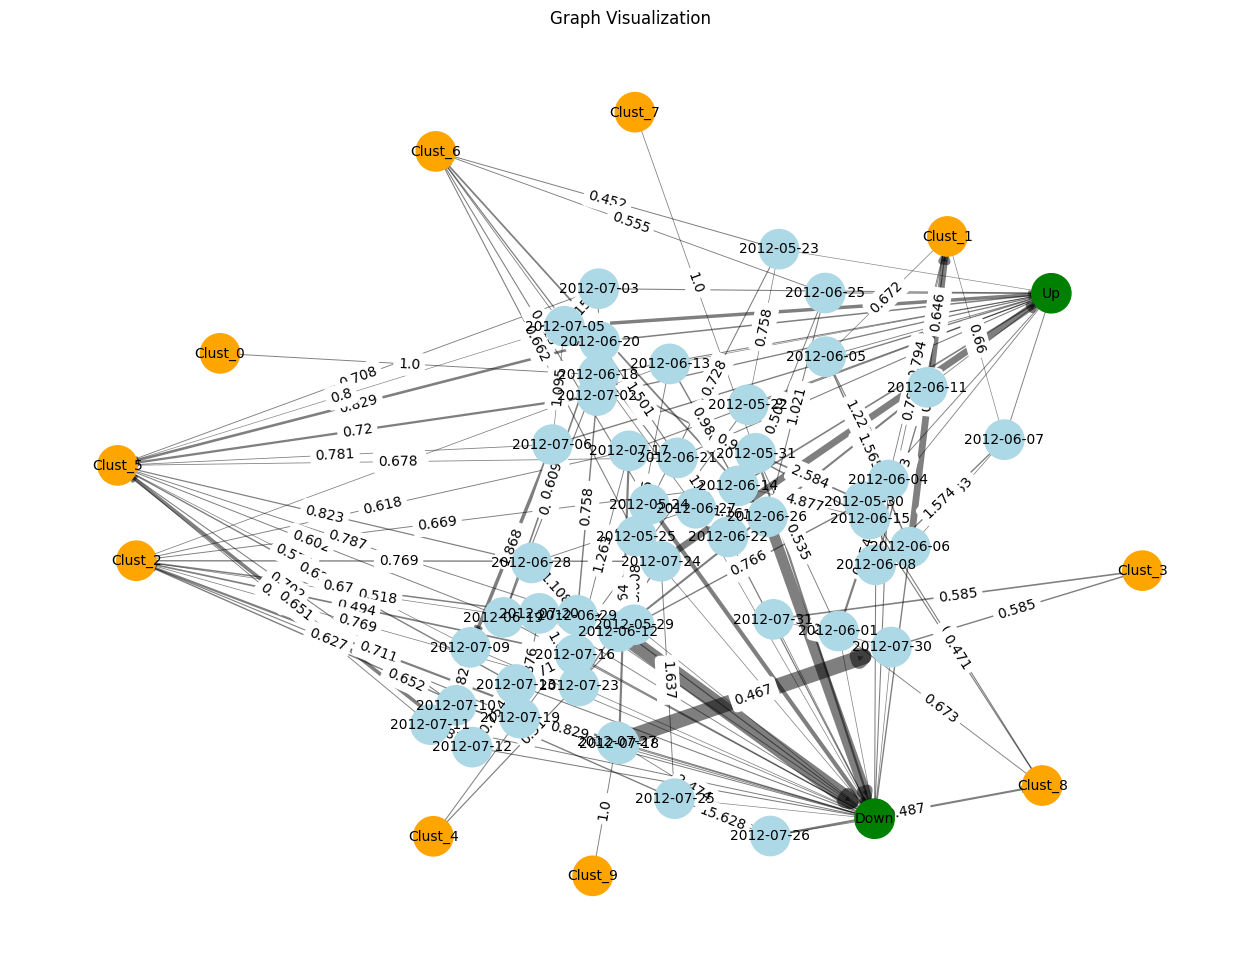

In [267]:
# 그래프 시각화
plt.figure(figsize=(16, 12))  # 그래프 크기 조정
pos = nx.spring_layout(G, k=0.5, iterations=50)  # 노드의 위치 결정, k값 조정하여 간격 증가
weights = nx.get_edge_attributes(G, 'weight')  # 엣지의 가중치 가져오기

# 노드 색상 설정
node_colors = [
    'green' if node in ['Up', 'Down'] else
    'orange' if 'Clust' in node else
    'lightblue'
    for node in G.nodes()
]

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors)
nx.draw_networkx_labels(G, pos, font_size=10)  # 노드 이름의 글자 크기 조정

# 엣지 그리기
nx.draw_networkx_edges(G, pos, width=list(weights.values()), alpha=0.5)

# 가중치 레이블 추가
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Graph Visualization")
plt.axis('off')  # 축 숨기기
plt.show()

## 3D Visualization

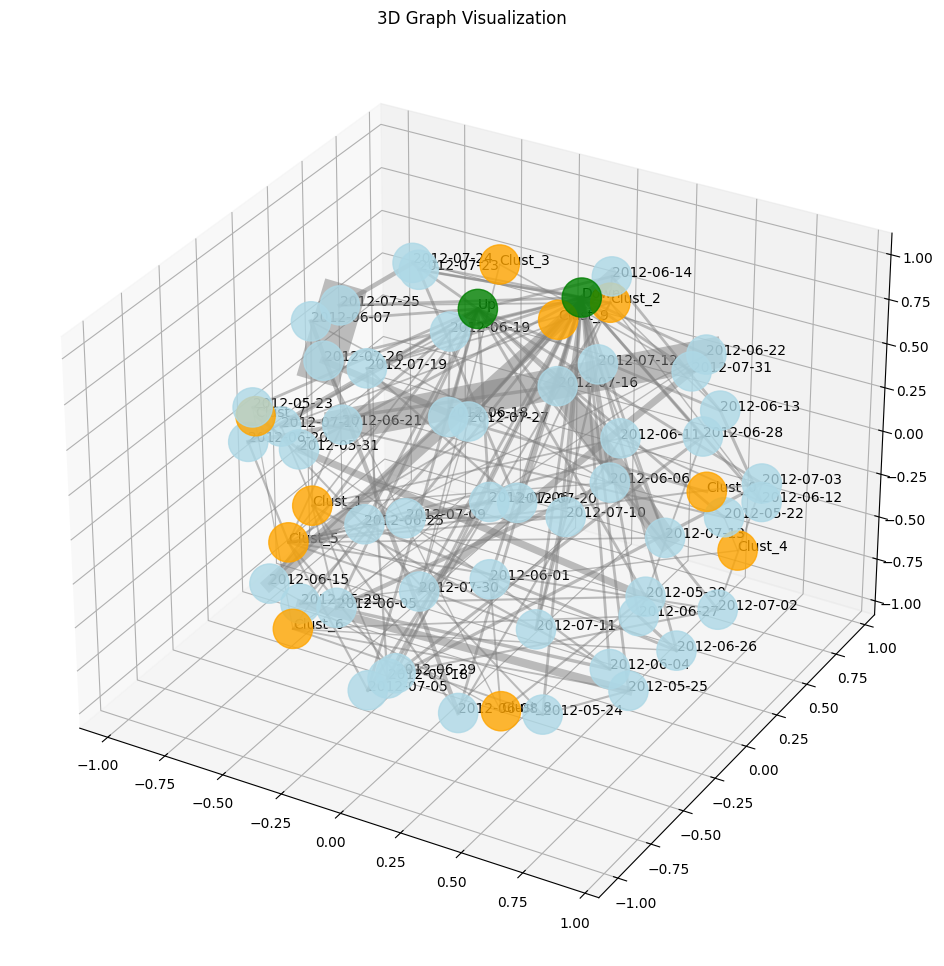

In [271]:
# 3D 그래프 시각화
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 3D 위치 결정 (k 값을 늘려서 간격 증가)
pos = nx.spring_layout(G, dim=3, k=5.0, iterations=50)  # k를 1.0으로 증가
weights = nx.get_edge_attributes(G, 'weight')  # 엣지의 가중치 가져오기

# 노드 색상 설정
node_colors = [
    'green' if node in ['Up', 'Down'] else
    'orange' if 'Clust' in node else
    'lightblue'
    for node in G.nodes()
]

# 노드 그리기
x = [pos[node][0] for node in G.nodes()]
y = [pos[node][1] for node in G.nodes()]
z = [pos[node][2] for node in G.nodes()]

ax.scatter(x, y, z, s=800, c=node_colors, alpha=0.8)

# 노드 레이블 추가
for node in G.nodes():
    ax.text(pos[node][0], pos[node][1], pos[node][2], node, size=10, zorder=1)

# 엣지 그리기
for edge in G.edges():
    x_edges = [pos[edge[0]][0], pos[edge[1]][0]]
    y_edges = [pos[edge[0]][1], pos[edge[1]][1]]
    z_edges = [pos[edge[0]][2], pos[edge[1]][2]]
    # 가중치를 안전하게 가져오기 위해 weights.get 사용
    weight = weights.get(edge, 1)  # 기본 가중치 1로 설정
    ax.plot(x_edges, y_edges, z_edges, color='gray', alpha=0.5, linewidth=weight * 2)

plt.title("3D Graph Visualization")
plt.show()